In [1]:
import sys
from pathlib import Path
srcdir = Path("../..").resolve()
print(f"Adding {srcdir} to sys.path, this is necessary to import from src")
sys.path.insert(0, str(srcdir))
print(sys.path)

import torch
from pathlib import Path
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

Adding /Users/rgrouls/code/ML22 to sys.path, this is necessary to import from src
['/Users/rgrouls/code/ML22', '/Users/rgrouls/code/ML22/notebooks/5_attention', '/Users/rgrouls/.pyenv/versions/3.9.16/lib/python39.zip', '/Users/rgrouls/.pyenv/versions/3.9.16/lib/python3.9', '/Users/rgrouls/.pyenv/versions/3.9.16/lib/python3.9/lib-dynload', '', '/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-HUU8cknU-py3.9/lib/python3.9/site-packages']


# Classsification Metrics
## 1 Confusion Matrix
To showcase a confusion matrix, let's load the Fashion MNIST data.

And we make a post-processing function that makes the label a 1 if the number is a four, and 0 otherwise.

In [2]:
from typing import List, Tuple
class DummyPreprocessor:
    def __call__(self, batch: List[Tuple]) -> Tuple[torch.Tensor, torch.Tensor]:
        batchsize = len(batch)
        # we allocate some memory. This speeds up filling the batch
        X = torch.zeros(size=(batchsize, 1, 28, 28)) 
        Y = []
        i = 0
        for x, y in batch:
            X[i] = x
            # the label will be True if 4, False otherwise
            Y.append(int(y == 4))
            i += 1
        return X, torch.tensor(Y, dtype=torch.long)


With this, we can create a Dataloader

In [3]:
from mads_datasets import DatasetFactoryProvider, DatasetType
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION, preprocessor=DummyPreprocessor)
datasets = fashionfactory.create_dataset()
train = datasets["train"]
valid = datasets["valid"]

2023-06-06 13:17:13.086 | INFO     | mads_datasets.datasetfactory:download_data:91 - Dataset already exists at /Users/rgrouls/.cache/mads_datasets/fashionmnist
2023-06-06 13:17:13.209 | INFO     | mads_datasets.datasetfactory:download_data:101 - Digest of downloaded /Users/rgrouls/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


Now our $y$ consists of zeros and ones

In [6]:
X, y = train[0]
X.shape, y.shape, y

(torch.Size([1, 28, 28]), torch.Size([]), tensor(9, dtype=torch.uint8))

We load our basic model.

The number of outputs should be 2, because we have two classes.
Let's run this with only 100 training-steps; that way we can see the progress better.

In [7]:
logdir = Path("modellogs/dummy")

In [8]:
from src.settings import TrainerSettings, ReportTypes
from src.models import metrics
accuracy = metrics.Accuracy()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir=logdir,
    train_steps=100,
    valid_steps=50,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN,],
    scheduler_kwargs={"factor": 0.5, "patience": 5},
)
settings

epochs: 3
metrics: [Accuracy]
logdir: modellogs/dummy
train_steps: 100
valid_steps: 50
reporttypes: [<ReportTypes.TENSORBOARD: 2>, <ReportTypes.GIN: 1>]
optimizer_kwargs: {'lr': 0.001, 'weight_decay': 1e-05}
scheduler_kwargs: {'factor': 0.5, 'patience': 5}
earlystop_kwargs: {'save': False, 'verbose': True, 'patience': 10}

In [10]:
streamers = fashionfactory.create_datastreamer(batchsize=32)
trainstreamer = streamers["train"]
validstreamer = streamers["valid"]

2023-06-06 13:19:08.594 | INFO     | mads_datasets.datasetfactory:download_data:91 - Dataset already exists at /Users/rgrouls/.cache/mads_datasets/fashionmnist
2023-06-06 13:19:08.734 | INFO     | mads_datasets.datasetfactory:download_data:101 - Digest of downloaded /Users/rgrouls/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


In [11]:
from src.models import imagemodels, train_model

model = imagemodels.CNN(2, (3,3), 32, 64)

trainer = train_model.Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer.stream(),
    validdataloader=validstreamer.stream(),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2023-06-06 13:19:32.807 | INFO     | src.data.data_tools:dir_add_timestamp:146 - Logging to modellogs/dummy/20230606-1319
2023-06-06 13:19:32.809 | INFO     | src.models.train_model:__init__:108 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:01<00:00, 70.65it/s]
2023-06-06 13:19:34.599 | INFO     | src.models.train_model:report:210 - Epoch 0 train 0.3268 test 0.2590 metric ['0.9081']
100%|██████████| 100/100 [00:01<00:00, 59.05it/s]
2023-06-06 13:19:36.607 | INFO     | src.models.train_model:report:210 - Epoch 1 train 0.2249 test 0.2012 metric ['0.9175']
100%|██████████| 100/100 [00:01<00:00, 67.45it/s]
2023-06-06 13:19:38.418 | INFO     | src.models.train_model:report:210 - Epoch 2 train 0.1848 test 0.1618 metric ['0.9244']
100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Naively, this looks very good. The first epoch is alreay at 90%. But not so fast... 
What would you expect from blind guessing? Exactly 90% accuracy if you would guess all 0! Because 90% is a 0!
That gives us a different perspective on the 90 or 94% you might get... So we need something more complex than just accuracy.

In [15]:
from tqdm import tqdm
y_true = []
y_pred = []

validdata = validstreamer.stream()
for _ in tqdm(range(len(validstreamer))):
    X, y = next(validdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)  # we get the one with the highest probability
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

100%|██████████| 312/312 [00:01<00:00, 164.40it/s]


Let's collect all predictions in a list, and flatten the list with a list comprehension.

With this, we can use the confusion matrix from sklearn and plot it with seaborn.

[Text(0.5, 80.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Target')]

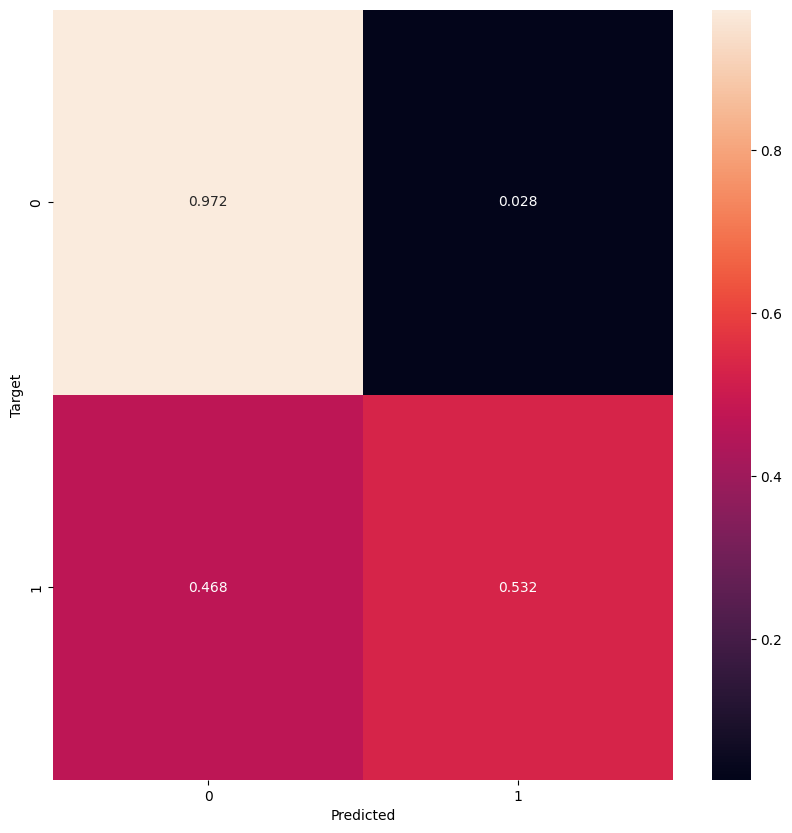

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve 

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

You can see that the target 0 is predicted as a 0 for 96% of the time. So that is going well.
However, the target 1 (number is a four) is predicted as actually 1 is much worse! 

## 2 Precision, Recall and F1
The F1-score is a useful metric for problems with unblanaced datasets; it returns a number between 0 and 1 that gives an indication of how well a model is doing in the classification task. Other useful metrics are *precision* and *recall*.

**Precision**: how many of the samples *predicted* as positive are actually positive

$$ Precision = \frac{TP}{TP + FP}$$

**Recall**: how many of *actual* positive samples are indeed predicted as positive

$$ Recall = \frac{TP}{TP + FN}$$

**F-score**: the harmonic mean of precision and recall

$$ F = 2 * \frac{precision * recall}{precision + recall} $$

The F1-score of the dummy classifier is zero! 
Lets first visualize the f1-metric:

/var/folders/27/8l0tbkzx7px4b1vn082g66qc0000gn/T/ipykernel_47091/3096192362.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * (prec*rec)/(prec+rec)


<Axes: >

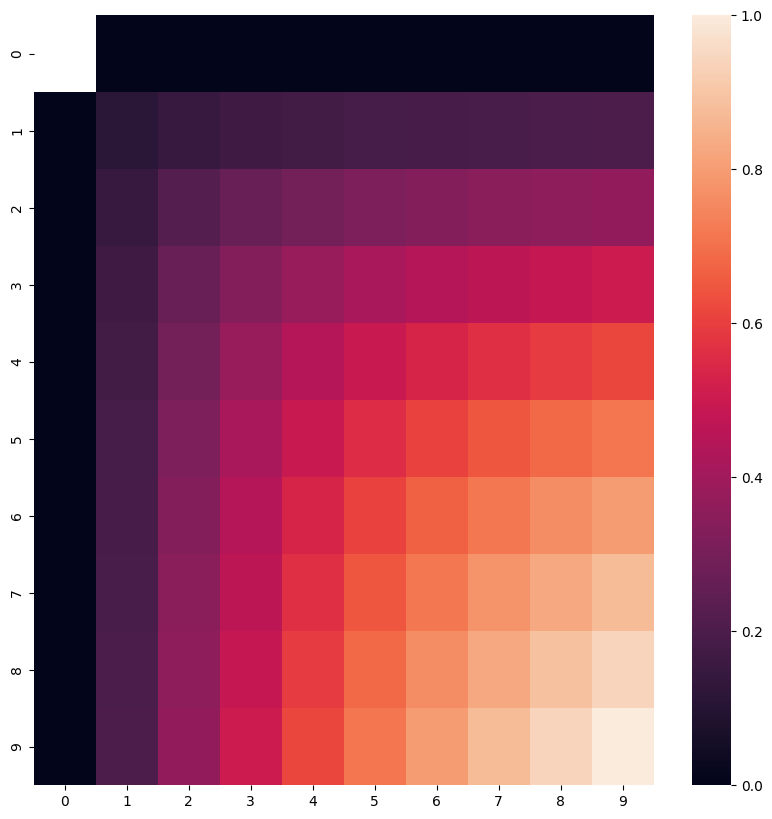

In [17]:
k = 10
prec = np.linspace(0, 1, k) # k precision values
rec = np.linspace(0, 1, k) # k recall values

def f1(prec, rec): # the f1 metric
    return 2 * (prec*rec)/(prec+rec)

from itertools import product
combinations = [f1(p,r) for p in prec for r in rec] # a list of combinations
grid = np.reshape(combinations, (k,k)) # reshaped into a grid
sns.heatmap(grid) # and heatmapped

This makes sense: if one of precision or recall is low, the outcome is low. If both are high, the outcome is high. This is a balanced mixture of both.

In [18]:
f1_score(y, yhat)

0.5956719817767654

As you can see, the f1 score is much more realistic than the accuracy.

Another approach is to look at precision-recall:

- recall describes how many correct items you actually retrieved, of all items you could have retrieved
- precision describes of the items you labeled, you actually labeled them correct.

For this, we are not going to look at the argmax, but directly at the logits of one of the classes.

In [20]:
y_true = []
y_pred = []


for _ in tqdm(range(len(validstreamer))):
    X, y = next(validdata)
    yhat = model(X)
    yhat = yhat[:, 1] # we get the probability of being a 4
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

100%|██████████| 312/312 [00:02<00:00, 150.14it/s]


<Axes: >

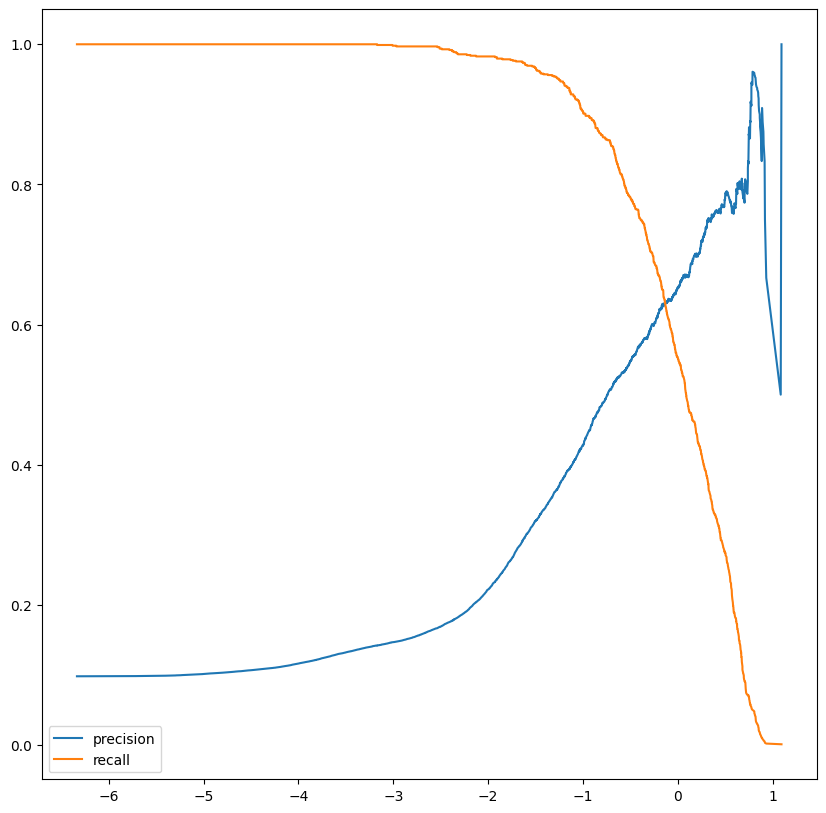

In [21]:
precision, recall, thresholds = precision_recall_curve(y, yhat)
n = len(thresholds)
sns.lineplot(x=thresholds, y=precision[:n], label="precision")
sns.lineplot(x=thresholds, y=recall[:n], label="recall")

Note how pushing the threshold up gives you a higher precision, but a lower recall, and the other way around. This is always a trade-off (do you understand why?)

Another way to visualize this trade off is with a ROC curve

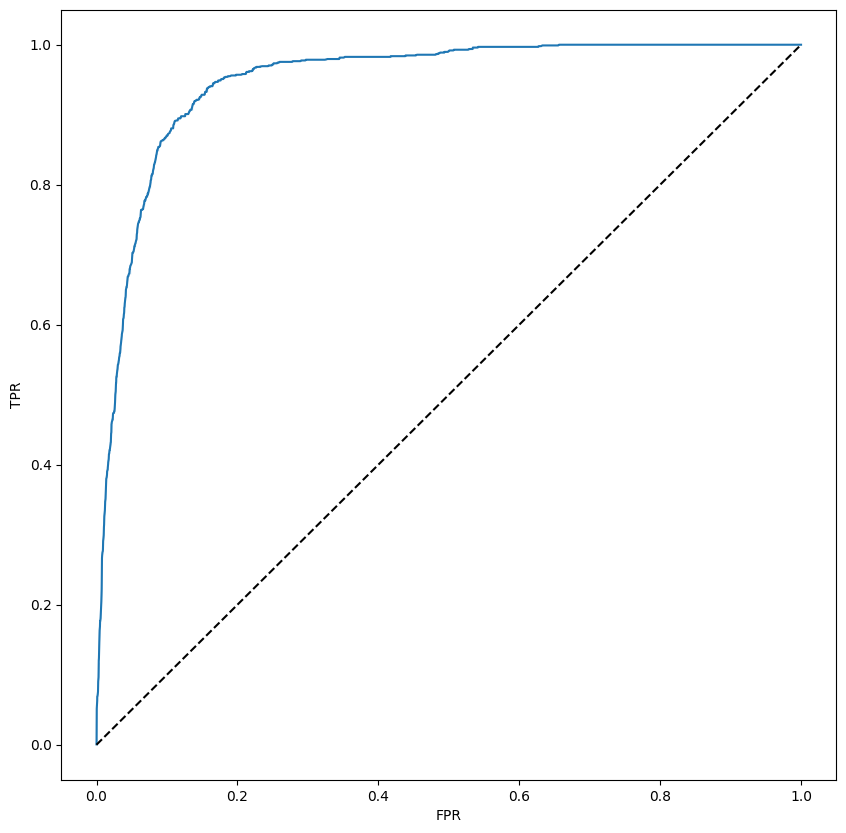

In [22]:
fpr, tpr, thresholds = roc_curve(y, yhat)
plot = sns.lineplot(x=fpr, y=tpr)
plot.set(xlabel="FPR", ylabel="TPR")
plt.plot([0,1], [0,1], "k--")

On the x-axis you see the False Positive Rate. In the beginning, the threshold is very low, so because you dont select any items your FPR is also low. But the same goes for your True Positive Rate.

As you increase the threshold, you start to find True Positives. This is good, but it comes with a price: you will also select False Positives. You can see that, as the TPR starts to rise, the FPR also rises.

Again, you are free to select a threshold to get any TPR you like. But the point of this curve is to maximize the area under the curve. In other words: the dotted diagonal line is what you would expect from blind guessing. Everything above the dotted line is an improvment beyond guessing. Models with a line that comes closer to the upper left corner are better.

Let's switch to the multi-label case. We drop the post-processing function, and train with 10 classes again.

In [23]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
streamers = fashionfactory.create_datastreamer(batchsize=32)
trainstreamer = streamers["train"]
validstreamer = streamers["valid"]

2023-06-06 13:25:00.699 | INFO     | mads_datasets.datasetfactory:download_data:91 - Dataset already exists at /Users/rgrouls/.cache/mads_datasets/fashionmnist
2023-06-06 13:25:00.858 | INFO     | mads_datasets.datasetfactory:download_data:101 - Digest of downloaded /Users/rgrouls/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


In [24]:
model = imagemodels.CNN(10, (3,3), 32, 64)
settings.epochs=10

trainer = train_model.Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer.stream(),
    validdataloader=validstreamer.stream(),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2023-06-06 13:25:21.052 | INFO     | src.data.data_tools:dir_add_timestamp:146 - Logging to modellogs/dummy/20230606-1325
2023-06-06 13:25:21.054 | INFO     | src.models.train_model:__init__:108 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:01<00:00, 69.64it/s]
2023-06-06 13:25:22.811 | INFO     | src.models.train_model:report:210 - Epoch 0 train 1.6827 test 1.0051 metric ['0.5587']
100%|██████████| 100/100 [00:01<00:00, 77.43it/s]
2023-06-06 13:25:24.376 | INFO     | src.models.train_model:report:210 - Epoch 1 train 0.9038 test 0.7925 metric ['0.6994']
100%|██████████| 100/100 [00:01<00:00, 79.79it/s]
2023-06-06 13:25:25.903 | INFO     | src.models.train_model:report:210 - Epoch 2 train 0.7815 test 0.7158 metric ['0.7175']
100%|██████████| 100/100 [00:01<00:00, 77.19it/s]
2023-06-06 13:25:27.494 | INFO     | src.models.train_model:report:210 - Epoch 3 train 0.7062 test 0.7915 metric ['0.7087']
2023-06-06 13:25:27.494 | IN

In [27]:
y_true = []
y_pred = []

validdata = validstreamer.stream()
for _ in range(len(validstreamer)):
    X, y = next(validdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

[Text(0.5, 80.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Target')]

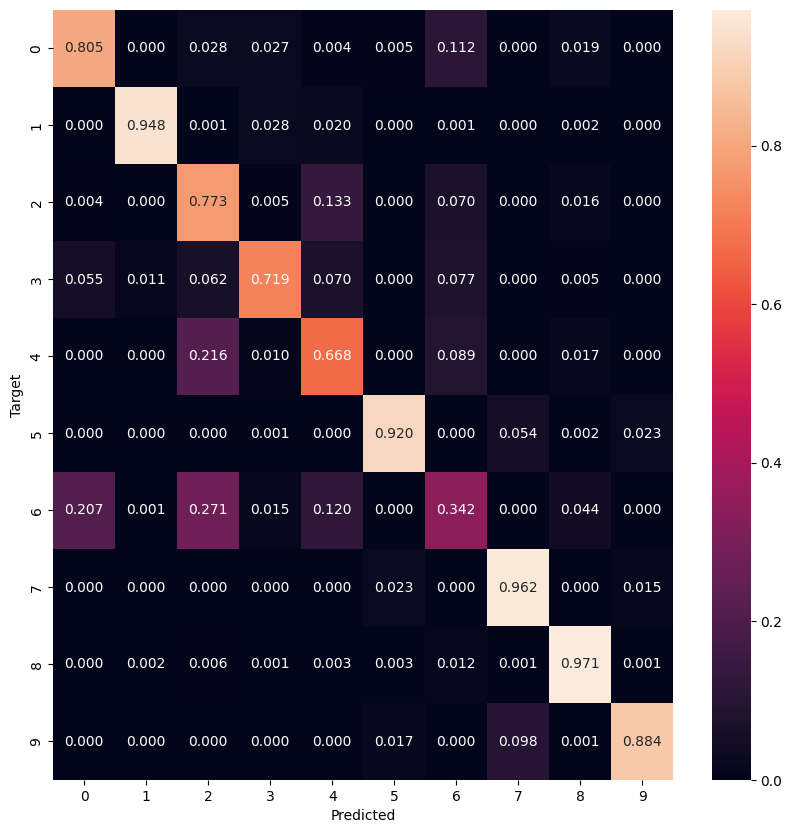

In [28]:
cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

This is a very efficient way to get an overview of the 100 different confusion-cases you could get.

At a glance, you can see which targets are mislabeled the most often, and if they are, what they are confused with for what percentage.